# 7. Extract image features

In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [2]:
#load data
data = pd.read_csv("data/metadata/selection_sharp.csv")

In [3]:
#create lists to store images arrays and labels
images = []
labels = []

#for the number of observations
for i in tqdm(range(len(data))):
    pil_img = Image.open(data.loc[i,"crop_storage"]) #read the image from the path
    np_img = np.array(pil_img) #turn it into an array
    np_img = np_img/255 #normalize pixel values
    images.append(np_img) #store it in the list
    labels.append(data.loc[i,"Scientific Name"]) #store the class in the list
    
#turn the lists into arrays
images = np.array(images)
labels = np.array(labels)

#print labels shape
print(images.shape)
print(labels.shape)

100%|██████████| 1508/1508 [00:07<00:00, 200.17it/s]


(1508, 224, 224, 3)
(1508,)


In [4]:
batch1 = images[:500,:,:,:]
batch2 = images[500:1000,:,:,:]
batch3 = images[1000:,:,:,:]

In [5]:
# Create graph
img_graph = tf.Graph()

with img_graph.as_default():
    # Download module
    module_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'
    feature_extractor = hub.Module(module_url)

    # Create input placeholder
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])

    # A node with the features
    imgs_features = feature_extractor(input_imgs)

    # Collect initializers
    init_op = tf.group([
        tf.global_variables_initializer(), tf.tables_initializer()
    ])

img_graph.finalize() # Good practice: make the graph "read-only"

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
# Create a session
sess = tf.Session(graph=img_graph)

# Initialize it
sess.run(init_op)

# Extract features
features1 = sess.run(imgs_features, feed_dict={input_imgs: batch1})
features2 = sess.run(imgs_features, feed_dict={input_imgs: batch2})
features3 = sess.run(imgs_features, feed_dict={input_imgs: batch3})
print(features1.shape)
print(features2.shape)
print(features3.shape)

(500, 1280)
(500, 1280)
(508, 1280)


In [7]:
#concatenate batches
features = np.concatenate((features1,features2,features3),axis=0)

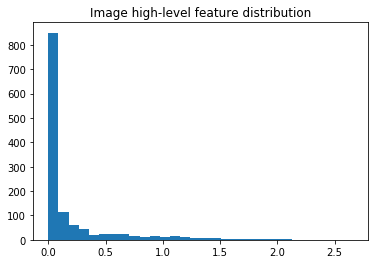

In [8]:
#plot the distribution of high-level features
plt.hist(features[0], bins=30)
plt.title('Image high-level feature distribution')
plt.show()

In [9]:
#save the high-level features in npz files
np.savez("data/image_features.npz", features=features, labels=labels)